In [1]:
import math
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
import nltk
import os.path
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.corpus import stopwords
import cv2
from PIL import Image
import string
import seaborn as sns
import pandas as pd
from torchvision.models import ResNet50_Weights


c:\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# dataset dir path
cocoapi_dir = r"D:\DLproject\coco2017"

import os
folders = [folder for folder in os.listdir(cocoapi_dir)]
folders

['annotations', 'images']

## Data Visualization

In [4]:
ann_file = os.path.join(cocoapi_dir, "annotations/captions_train2017.json")

# Load COCO annotations
coco = COCO(ann_file)




loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


Sample Captions: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']


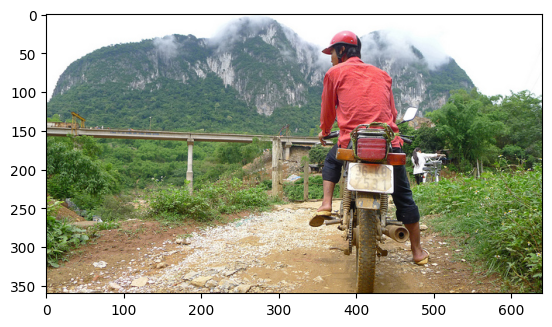

In [24]:
# Get all image IDs
image_ids = list(coco.imgs.keys())


sample_img_id = image_ids[0]  # Pick the first image ID
ann_ids = coco.getAnnIds(imgIds=sample_img_id)  # Get annotation IDs for that image
captions = [coco.anns[ann]['caption'] for ann in ann_ids]  # Extract actual captions
img_info = coco.imgs[sample_img_id]
img_path = os.path.join(cocoapi_dir, "images/train2017", img_info['file_name'])
image = Image.open(img_path)
plt.imshow(image)
print("Sample Captions:", captions)


In [25]:
# Number of images and captions
num_images = len(image_ids)
num_captions = sum([len(coco.getAnnIds(imgIds=img_id)) for img_id in image_ids])

print(f"Total Images: {num_images}")
print(f"Total Captions: {num_captions}")

# Sample image details
first_image = coco.imgs[image_ids[0]]
print("Sample Image Metadata:", first_image)



Total Images: 118287
Total Captions: 591753
Sample Image Metadata: {'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


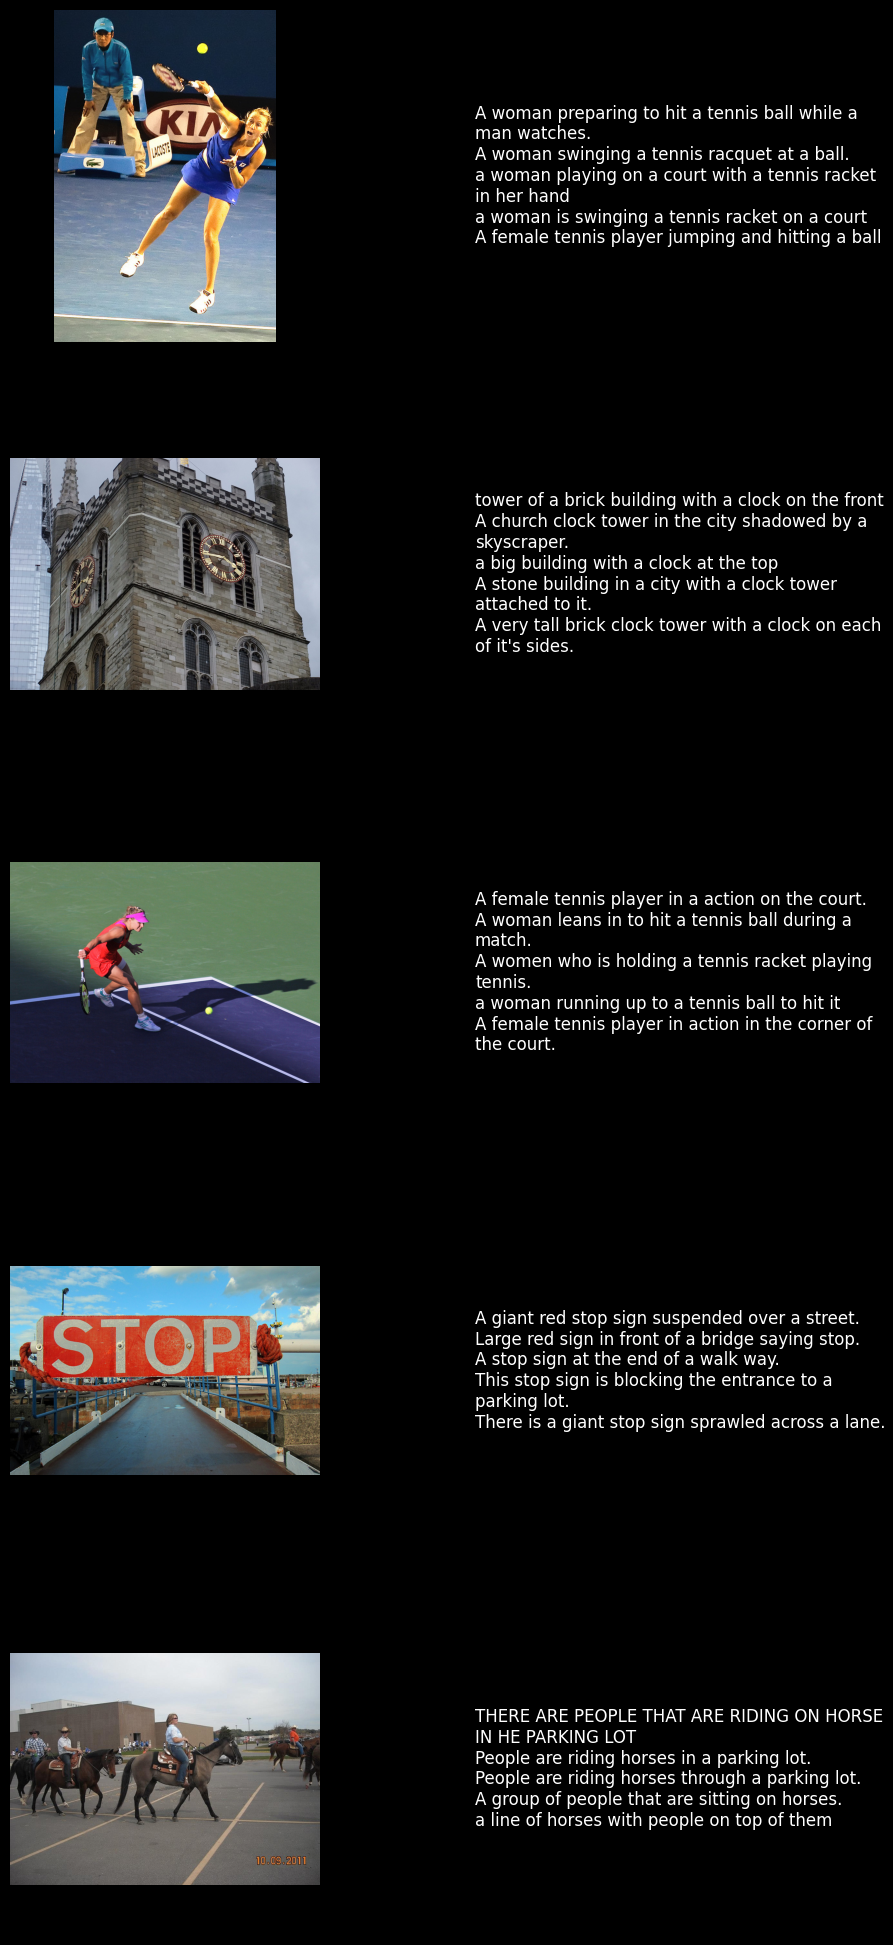

In [26]:
def show_sample_images(num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Creating a 2-column layout
    fig.patch.set_facecolor('black')  # Set figure background to black

    for i in range(num_samples):
        # Randomly pick an image
        img_id = random.choice(image_ids)
        img_info = coco.imgs[img_id]
        img_path = os.path.join(cocoapi_dir, "images/train2017", img_info['file_name'])
        
        # Load and display the image in the first column
        image = Image.open(img_path)
        axes[i, 0].imshow(image)
        axes[i, 0].set_facecolor('black')  # Set subplot background to black
        axes[i, 0].axis('off')  # Remove axis for clean visualization
        
        # Fetch captions
        ann_ids = coco.getAnnIds(imgIds=img_id)
        captions = [coco.anns[ann]['caption'] for ann in ann_ids]
        
        # Display captions in the second column
        caption_text = "\n".join(captions)  # Concatenating multiple captions
        axes[i, 1].set_facecolor('black')  # Set subplot background to black
        axes[i, 1].text(0, 0.5, caption_text, fontsize=12, verticalalignment='center', 
                        wrap=True, color='white')  # White text
        axes[i, 1].axis('off')  # Hide axes in text area
    
    plt.subplots_adjust(wspace=0.5)  # Add space between image and caption
    plt.show()

# Show sample images
show_sample_images(5)


In [ ]:
def preprocess_caption(caption):
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation))  # Lowercase & remove punctuation
    tokens = nltk.word_tokenize(caption)  # Tokenize
    return tokens

all_captions = []
for img_id in image_ids:  
    ann_ids = coco.getAnnIds(imgIds=img_id)
    for ann in ann_ids:
        tokens = preprocess_caption(coco.anns[ann]['caption'])
        all_captions.append(tokens)

In [34]:
word_counts = Counter([word for caption in all_captions for word in caption])

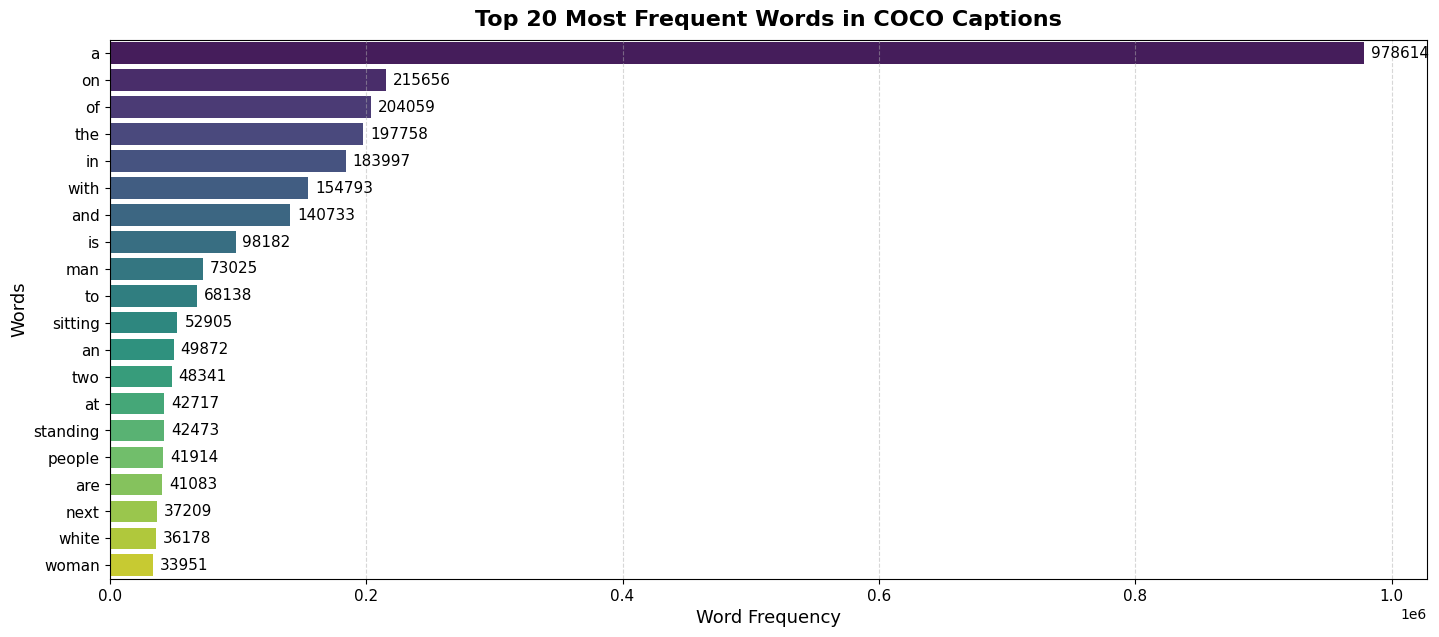

In [ ]:
# Convert word_counts dictionary to DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by="count", ascending=False)

# Get top 20 most frequent words
top_words_df = word_freq_df.head(20)

# Set up the plot
plt.figure(figsize=(17, 7))
ax = sns.barplot(x="count", y="word", data=top_words_df, legend=False, hue ='word', palette="viridis")

# Improve aesthetics
plt.title("Top 20 Most Frequent Words in COCO Captions", fontsize=16, fontweight='bold', pad=10)
plt.xlabel("Word Frequency", fontsize=13)
plt.ylabel("Words", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add value labels correctly
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Add a grid for clarity
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Show the plot
plt.show()


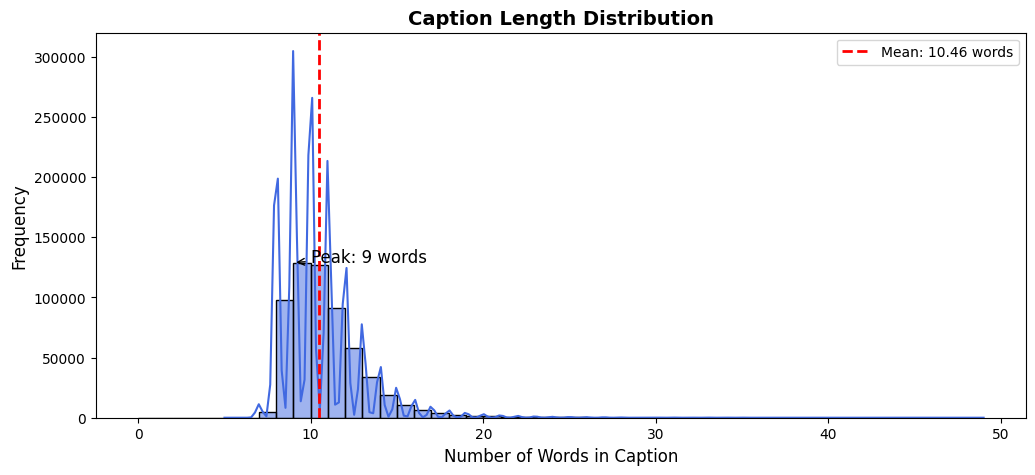

In [41]:
caption_lengths = [len(caption) for caption in all_captions]

plt.figure(figsize=(12, 5))

# Use bin width of 1 for finer granularity
ax = sns.histplot(caption_lengths, bins=range(0, max(caption_lengths), 1), kde=True, color="royalblue")

# Add labels and title
plt.title("Caption Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words in Caption", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add mean and median lines
mean_length = sum(caption_lengths) / len(caption_lengths)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f"Mean: {mean_length:.2f} words")

# Annotate the peak caption length
max_bin = max(set(caption_lengths), key=caption_lengths.count)
plt.annotate(f"Peak: {max_bin} words", xy=(max_bin, caption_lengths.count(max_bin)), 
             xytext=(max_bin + 1, caption_lengths.count(max_bin) + 30),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12)

plt.legend()
plt.show()



loading annotations into memory...
Done (t=10.20s)
creating index...
index created!


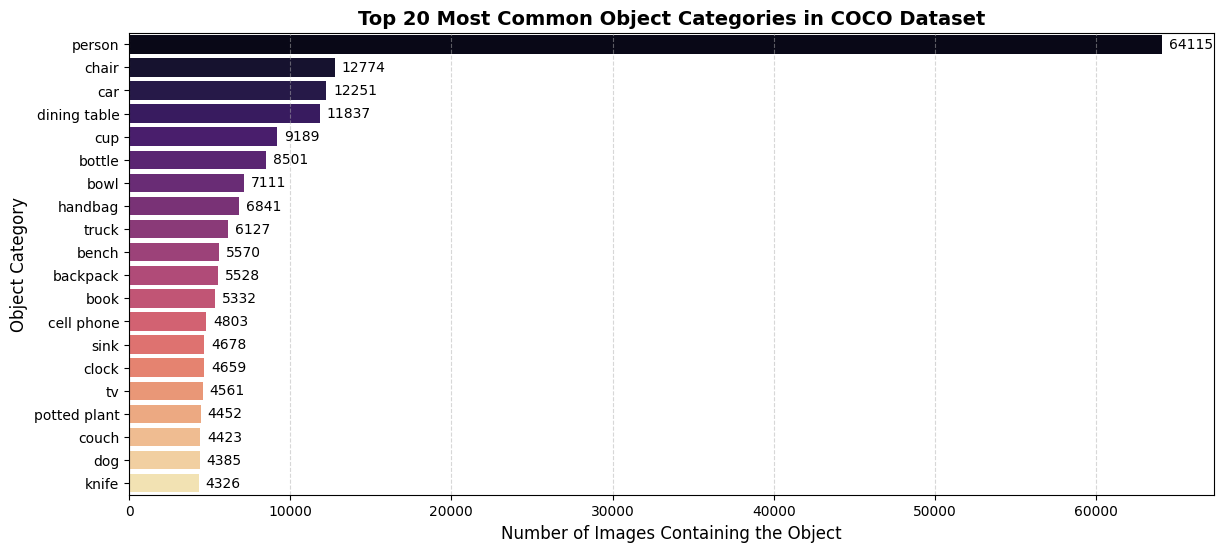

In [48]:
# Load object instance annotations
instances_file = os.path.join(cocoapi_dir, "annotations/instances_train2017.json")
coco_instances = COCO(instances_file)

# Ensure COCO dataset is loaded correctly
if not hasattr(coco_instances, "getCatIds"):
    raise ValueError("COCO dataset is not loaded properly. Check 'coco_instances' initialization.")

# Get category names and their IDs
categories = coco_instances.loadCats(coco_instances.getCatIds())

# Count object occurrences in images
category_counts = {cat['name']: len(coco_instances.getImgIds(catIds=[cat['id']])) for cat in categories}

# Convert to DataFrame
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# Sort and select the top 20 object categories
top_categories_df = category_counts_df.nlargest(20, "Count")

# Set up the plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Count", y="Category", data=top_categories_df, hue="Category", legend=False, palette="magma")

# Improve aesthetics
plt.title("Top 20 Most Common Object Categories in COCO Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Number of Images Containing the Object", fontsize=12)
plt.ylabel("Object Category", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels correctly
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Add a grid for clarity
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Show the plot
plt.show()


## Model, dataset, vocabulary preparation

In [48]:
batch_size = 64  # batch size
vocab_threshold = 5  # minimum word count threshold
vocab_from_file = False  # if True, load existing vocab file
embed_size = 256  # dimensionality of image and word embeddings
hidden_size = 512  # number of features in hidden state of the RNN decoder
num_epochs = 3  # number of training epochs
save_every = 1  # determines frequency of saving model weights
print_every = 40  # determines window for printing average loss
log_file = "training_log.txt"  # name of file with saved training loss and perplexity

In [4]:
transform_train = transforms.Compose(
    [
        # smaller edge of image resized to 256
        transforms.Resize(256),
        # get 224x224 crop from random location
        transforms.RandomCrop(224),
        # horizontally flip image with probability=0.5
        transforms.RandomHorizontalFlip(),
        # convert the PIL Image to a tensor
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [5]:
transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [6]:
class Vocabulary(object):
    def __init__(
        self,
        vocab_threshold,
        vocab_file="./vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file="../annotations/captions_train2017.json",
        vocab_from_file=False,
    ):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab.pkl file!")

        # create a new vocab file
        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, idx in enumerate(ids):
            caption = str(coco.anns[idx]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [25]:
class CoCoDataset(data.Dataset):
    def __init__(
        self,
        transform,
        mode,
        batch_size,
        vocab_threshold,
        vocab_file,
        start_word,
        end_word,
        unk_word,
        annotations_file,
        vocab_from_file,
        img_folder,
    ):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(
            vocab_threshold,
            vocab_file,
            start_word,
            end_word,
            unk_word,
            annotations_file,
            vocab_from_file,
        )
        self.img_folder = img_folder
        if self.mode == "train":
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print("Obtaining caption lengths...")
            all_tokens = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]["caption"]).lower()
                )
                for index in tqdm(np.arange(len(self.ids)))
            ]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == "train":
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        elif self.mode == "valid":
            path = self.paths[index]
            image_id = int(path.split("/")[0].split(".")[0].split("_")[-1])
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(pil_image)

            # return original image and pre-processed image tensor
            return image_id, image
        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            orig_image = np.array(pil_image)
            image = self.transform(pil_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [
                self.caption_lengths[i] == sel_length
                for i in np.arange(len(self.caption_lengths))
            ]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == "train":
            return len(self.ids)
        else:
            return len(self.paths)


In [26]:
def get_loader(
    transform,
    mode="valid",
    batch_size=1,
    vocab_threshold=None,
    vocab_file="./vocab.pkl",
    start_word="<start>",
    end_word="<end>",
    unk_word="<unk>",
    vocab_from_file=True,
    num_workers=0,
    cocoapi_loc="/opt",
):
    assert mode in ["train", "valid", "test"], "mode must be one of 'train' or 'test'."
    if not vocab_from_file:
        assert (
            mode == "train"
        ), "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == "train":
        if vocab_from_file:
            assert os.path.exists(
                vocab_file
            ), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, "images/train2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/captions_train2017.json"
        )
    elif mode == "test":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(
            vocab_file
        ), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "images/test2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/image_info_test2017.json"
        )
    elif mode == "valid":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(
            vocab_file
        ), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "images/val2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/captions_val2017.json"
        )
    else:
        raise ValueError(f"Invalid mode: {mode}")
    # COCO caption dataset.
    dataset = CoCoDataset(
        transform=transform,
        mode=mode,
        batch_size=batch_size,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_word=start_word,
        end_word=end_word,
        unk_word=unk_word,
        annotations_file=annotations_file,
        vocab_from_file=vocab_from_file,
        img_folder=img_folder,
    )

    if mode == "train":
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(
            dataset=dataset,
            # pin_memory=True,
            num_workers=num_workers,
            batch_sampler=data.sampler.BatchSampler(
                sampler=initial_sampler, batch_size=dataset.batch_size, drop_last=False
            ),
        )
    else:
        data_loader = data.DataLoader(
            dataset=dataset,
            # pin_memory=True,
            batch_size=dataset.batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    return data_loader

In [49]:
# Building data loaders.

train_data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

val_data_loader = get_loader(
    transform=transform_test, mode="valid", cocoapi_loc=cocoapi_dir
)



loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:23<00:00, 25481.63it/s]


Vocabulary successfully loaded from vocab.pkl file!


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models


# ----------- Encoder ------------
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # disable learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


# --------- Decoder ----------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()

        # Assigning hidden dimension
        self.hidden_dim = hidden_size
        # Map each word index to a dense word embedding tensor of embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Creating LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # Initializing linear to apply at last of RNN layer for further prediction
        self.linear = nn.Linear(hidden_size, vocab_size)
        # Initializing values for hidden and cell state
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        """
        Args:
            features: features tensor. shape is (bs, embed_size)
            captions: captions tensor. shape is (bs, cap_length)
        Returns:
            outputs: scores of the linear layer

        """
        # remove <end> token from captions and embed captions
        cap_embedding = self.embed(
            captions[:, :-1]
        )  # (bs, cap_length) -> (bs, cap_length-1, embed_size)

        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        #  getting output i.e. score and hidden layer.
        # first value: all the hidden states throughout the sequence. second value: the most recent hidden state
        lstm_out, self.hidden = self.lstm(
            embeddings
        )  # (bs, cap_length, hidden_size), (1, bs, hidden_size)
        outputs = self.linear(lstm_out)  # (bs, cap_length, vocab_size)

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """
        accepts pre-processed image tensor (inputs) and returns predicted
        sentence (list of tensor ids of length max_len)
        Args:
            inputs: shape is (1, 1, embed_size)
            states: initial hidden state of the LSTM
            max_len: maximum length of the predicted sentence

        Returns:
            res: list of predicted words indices
        """
        res = []

        # Now we feed the LSTM output and hidden states back into itself to get the caption
        for i in range(max_len):
            lstm_out, states = self.lstm(
                inputs, states
            )  # lstm_out: (1, 1, hidden_size)
            outputs = self.linear(lstm_out.squeeze(dim=1))  # outputs: (1, vocab_size)
            _, predicted_idx = outputs.max(dim=1)  # predicted: (1, 1)
            res.append(predicted_idx.item())
            # if the predicted idx is the stop index, the loop stops
            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx)  # inputs: (1, embed_size)
            # prepare input for next iteration
            inputs = inputs.unsqueeze(1)  # inputs: (1, 1, embed_size)

        return res


In [34]:

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
def clean_sentence(output, idx2word):
    sentence = ""
    for i in output:
        word = idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + " " + word
    return sentence


def bleu_score(true_sentences, predicted_sentences):
    smoothing_fn = SmoothingFunction().method1  # You can try other methods if needed
    hypotheses = []
    references = []
    common_ids = set(true_sentences.keys()).intersection(set(predicted_sentences.keys()))
    for img_id in common_ids:
        # Get predicted caption tokens
        pred_tokens = predicted_sentences[img_id][0].strip().split()
        # Skip if predicted caption is empty
        if not pred_tokens:
            continue
        
        # Get references tokens; skip any empty reference captions
        img_refs = [cap.split() for cap in true_sentences[img_id] if cap.strip()]
        if not img_refs:
            continue
        
        hypotheses.append(pred_tokens)
        references.append(img_refs)
    
    # If no valid hypotheses exist, return 0.0 to avoid division by zero.
    if len(hypotheses) == 0:
        return 0.0
    
    return corpus_bleu(references, hypotheses, smoothing_function=smoothing_fn)


## Training

In [12]:
# The size of the vocabulary.
vocab_size = len(train_data_loader.dataset.vocab)
print("vocab size is : ",vocab_size)

# Initializing the encoder and decoder
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Defining the loss function
criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

# Specifying the learnable parameters of the mode
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Defining the optimize
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoc
total_step = math.ceil(len(train_data_loader.dataset) / train_data_loader.batch_sampler.batch_size)
print(total_step)

vocab size is :  10321
9247


In [35]:
# --- Build ground-truth captions dictionary from validation annotations ---
val_annotations_file = os.path.join(cocoapi_dir, "annotations/captions_val2017.json")
from pycocotools.coco import COCO
val_coco = COCO(val_annotations_file)

# Create a dictionary mapping each image_id to its list of ground truth captions.
true_sentences = {}
ann_ids = val_coco.getAnnIds()
annotations = val_coco.loadAnns(ann_ids)
for ann in annotations:
    img_id = ann["image_id"]
    if img_id not in true_sentences:
        true_sentences[img_id] = []
    true_sentences[img_id].append(ann["caption"])

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
# Load model checkpoints
encoder.load_state_dict(torch.load(os.path.join("./models", "encoder-5.pkl")))
decoder.load_state_dict(torch.load(os.path.join("./models", "decoder-5.pkl")))

# Move models to device
encoder.to(device)
decoder.to(device)

# Load optimizer state if available (optional but recommended)
optimizer = torch.optim.Adam(params, lr=0.001)
if os.path.exists(os.path.join("./models", "optimizer-5.pth")):
    optimizer.load_state_dict(torch.load(os.path.join("./models", "optimizer-5.pth")))


In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

# --- Training loop ---
f = open(log_file, "a+")
num_epochs = 1  # change as needed
start_epoch = 6

for epoch in range(start_epoch, start_epoch + num_epochs):
    decoder.train()
    encoder.train()
    print(f"\nEpoch {epoch}/{start_epoch + num_epochs - 1}")
    progress_bar = tqdm(range(1, total_step + 1), desc="Training", unit="step")

    for i_step in progress_bar:
        # Randomly sample a caption length and obtain indices.
        indices = train_data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_data_loader.batch_sampler.sampler = new_sampler

        # Obtain a batch.
        images, captions = next(iter(train_data_loader))
        images = images.to(device)
        captions = captions.to(device)

        # Zero gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Forward pass.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass and optimization.
        loss.backward()
        optimizer.step()

        # Update progress bar.
        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Perplexity": f"{np.exp(loss.item()):.4f}"
        })

        # Log training stats.
        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )
        f.write(stats + "\n")
        f.flush()
    
    # Optionally, you could save model checkpoints.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join("./models", f"decoder-{epoch}.pkl"))
        torch.save(encoder.state_dict(), os.path.join("./models", f"encoder-{epoch}.pkl"))
        torch.save(optimizer.state_dict(), os.path.join("./models", f"optimizer-{epoch}.pth"))

# Close the training log file.
f.close()



Epoch 1/1


Training: 100%|██████████| 9247/9247 [2:32:46<00:00,  1.01step/s, Loss=2.0723, Perplexity=7.9434]   


Performing Validation...


Validation: 100%|██████████| 5000/5000 [02:40<00:00, 31.13batch/s]


Validation BLEU Score: 0.0000


RuntimeError: File ./models\decoder-1.pkl cannot be opened.

In [39]:
# infer captions for all images
pred_result = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder(img).unsqueeze(1)
        output = decoder.sample(features)
    sentence = clean_sentence(output, val_data_loader.dataset.vocab.idx2word)
    pred_result[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [01:59<00:00, 41.85it/s]


In [57]:
valid_result[190236]

['an office cubicle with four different types of computers.',
 'the home office space seems to be very cluttered.',
 'an office with desk computer and chair and laptop.',
 'office setting with a lot of computer screens.',
 'a desk and chair in an office cubicle.']

In [58]:
pred_result[190236]


[' a desk with a laptop and a desktop computer .']

In [ ]:
def get_image_by_id(dataset, target_img_id):
    for img_id, image in dataset:
        if img_id == target_img_id:
            return image
    return None

# Usage:
image = get_image_by_id(val_data_loader.dataset, 190236)
if image is not None:
    
    pass
else:
    print("Image not found.")

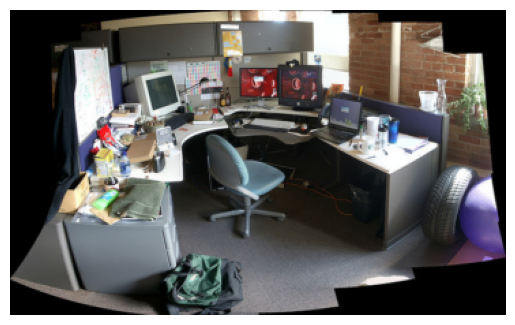

In [62]:
def imshow(image_tensor):
    # Convert tensor to numpy array
    image_np = image_tensor.cpu().numpy()
    # Image tensor is typically in (C, H, W) format; transpose to (H, W, C)
    image_np = np.transpose(image_np, (1, 2, 0))
    
    # If you applied normalization, you need to unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

imshow(image)

In [40]:
with open(
    #os.path.join(cocoapi_dir, "cocoapi", "annotations/captions_val2014.json"), "r"
    os.path.join(cocoapi_dir, "annotations/captions_val2017.json"), "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

In [53]:
list(valid_result.values())[:9]

[['a black honda motorcycle parked in front of a garage.',
  'a honda motorcycle parked in a grass driveway',
  'a black honda motorcycle with a dark burgundy seat.',
  'ma motorcycle parked on the gravel in front of a garage',
  'a motorcycle with its brake extended standing outside'],
 ['an office cubicle with four different types of computers.',
  'the home office space seems to be very cluttered.',
  'an office with desk computer and chair and laptop.',
  'office setting with a lot of computer screens.',
  'a desk and chair in an office cubicle.'],
 ['a small closed toilet in a cramped space.',
  'a tan toilet and sink combination in a small room.',
  'this is an advanced toilet with a sink and control panel.',
  'a close-up picture of a toilet with a fountain.',
  'off white toilet with a faucet and controls. '],
 ['two women waiting at a bench next to a street.',
  'a woman sitting on a bench and a woman standing waiting for the bus.',
  'a woman sitting on a bench in the middle 

In [52]:
list(pred_result.values())[:9]

[[' a motorcycle parked on a street next to a building .'],
 [' a man riding a surfboard on a wave in the ocean .'],
 [' a motorcycle parked on a gravel road near a building .'],
 [' a man is standing in a kitchen with a pot on the stove .'],
 [' a woman is standing on a tennis court with a racket .'],
 [' a fire hydrant is on a city street .'],
 [' a bathroom with a toilet ,sink , and mirror .'],
 [' a group of sheep grazing in a field .'],
 [' a woman is sitting on a bed with a stuffed animal .']]

In [ ]:
bleu_score(true_sentences=valid_result, predicted_sentences=pred_result)

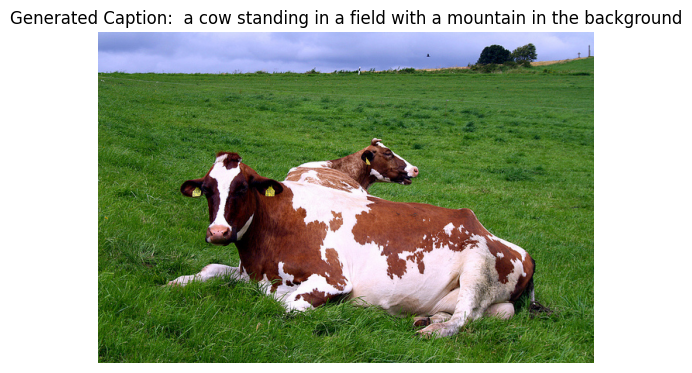

In [51]:
from PIL import Image
import torch
from torchvision import transforms
# from model import EncoderCNN, DecoderRNN
# from nlp_utils import clean_sentence
import os
import pickle
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the necessary parameters
embed_size = 256  # Assuming it's the same as during training
hidden_size = 512  # Assuming it's the same as during training
vocab_file = "vocab.pkl"  # Assuming the name of the vocabulary file

# Load the vocabulary
with open(vocab_file, "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

# Load the trained weights
encoder_file = "encoder-1.pkl"  # Update with the appropriate file name
decoder_file = "decoder-1.pkl"  # Update with the appropriate file name

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Load the test image
test_image_path = r"D:\DLproject\myproject\000000000019.jpg"  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()
